**I am working out on using auto encoders for pixel wise segmentation and which is what today we also call as semantic segmentation problems. I am going to use it on medical images and the class of images, which i use over here are images of retinal scans. The retina is the innermost, light-sensitive layer of tissue of the eye and where which has all of our photo sensory neurons present over there.
Now, since like it has those photo sensory neurons. So, we have our blood vessels also which go and carry down blood and over here the whole objective is that when there is an equipment called as ophthalmoscope, with which you can actually take an image of the rear part of your eye, then the whole objective is to segment out these blood vessels. And this goes into a very practical problem. Because say, like whenever there is some sort of a disease. So, we have some damaged out tissues which are also called as lesions, and their location with respect to this blood vessel is quite critical for medical diagnosis.**

In [1]:
# Dependencies

%matplotlib inline
import os
import struct
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import random
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy

**Data Set:There is a very famous data set openly available called as a DRIVE (digital retinal images for vessel extraction). Download Link: https://www.isi.uu.nl/Research/Databases/DRIVE/download.php .**

**It has typically 3 bunch of images over there. One image is the actual image of the retina, there is another image which has all the vessels marked out correctly like, whatever is a ground truth of the vessels, there is another image which is just called as a mask. So, what that does is, the valid regions where you have the retinal image taken is what is marked as white and rest everything is darkened out. But here i just need the retinal images and the vessel maps over there in order to train it and here the point is that it is no more trying to give a diagnosis out of one image.So, it is not like i have one image as an input to the auto encoder and i get a class label as output, but here it is more of like, there are multiple pixels on the image and i will have to label each and every single pixel over there. So, this kind of a problem where we have a simple segmentation approach being solved to mark out and annotate and classify each and every pixel on the image that is what is also called as a semantic segmentation. So, the first step of this is what we are going to do with an auto encoder.**

In [2]:
# Data Path
Datapath = 'DRIVE/training/images/'
Labelpath = 'DRIVE/training/1st_manual/'

**I will take the whole patch as my input to the network and features around a particular pixel on that patch is what will be learn within the network by the auto encoder itself. So, initially for sampling out these random locations, our idea is just to write down a function over there. So, what it does is, it defines out a small array, which is of the same size with
an height as the normal image. Now, on the image annotation that is what is defined as a bh x wh x 3 which means that, it is 10 x 10 x 3 given that I have an RGB image, and my labels over there for the particular patch is what is bh x wh x 1. Because it is just either 0 or 1, it is one single plane over there and nothing beyond it. Next part of my code just randomly selects out locations of where I can select out these patches.**

In [3]:
# Crop Image
# crop random 10 x 10 patches from images and also crop corresponding label

def img_transfer(img,imgLabel, bh, bw, no_of_patch):
    
    h = img.shape[0]
    w = img.shape[1]
    c = img.shape[2]
    ImgArr = np.empty((no_of_patch, bh*bw*3))
    LabelArr = np.empty((no_of_patch, bh*bw*1))

    for i in range(no_of_patch):
        ih = random.randint(0, h-bh)
        iw = random.randint(0, w-bw)
        iArrI = img[ih:ih+bh,iw:iw+bw,:]
        iArrL = imgLabel[ih:ih+bh,iw:iw+bw,:]       
        for ci in range(c):
            for bhi in range(bh):
                for bwi in range(bw):
                    ImgArr[i][ci*bh*bw + bhi*bw + bwi] = iArrI[bhi][bwi][ci]
                    if ci ==0:
                        LabelArr[i][ci*bh*bw + bhi*bw + bwi] = iArrL[bhi][bwi][ci]
        
    return ImgArr,LabelArr

**So, here I start by defining my actual patch size in terms of patch height and patch width, as well as the number of patches per image. So, what I define is I would like to have down 1000 random patches selected per image.**

In [4]:
patchH = 10 # height of the patch
patchW = 10 # width of the patch
PatchperImage = 1000 # no of patches per image

**Now, I need some place to store all of them. So, 1 tensor being created out. Now, here I decided to take 1000 of these 1’s, each of size 10 cross 10 and they are gray scale. So, typically then it would be basically 1000 x 3 x 10 x 10. However, I basically have 20 images available in my training. So, 1000 patches taken down from each image and there are 20 such images. So, you would be getting down 20000 of such training patches created out in 1 single batch and that is the size over here which I do for my training images, and similarly is a matrix which is defined for my training labels as well.**

In [5]:
TrainImages = torch.DoubleTensor(20*PatchperImage,3*patchH*patchW)
TrainLabels = torch.LongTensor(20*PatchperImage,patchH*patchW)

**Now, I am just going to randomly crop and patch out each of these part. So, I will have to actually open up the image. Once the image has been opened up, then i need to have some sort of randomized selection of locations from where i am going to patch it out, and once that is done i store it in my array over there.**

In [6]:
# Read each training image and crop random patches

t_no = 0
for img_no in range(20):
    imD = Image.open(Datapath + str(img_no+21) + '_training.tif')
    imD = np.array(imD)    
    
    imL = Image.open(Labelpath + str(img_no+21) + '_manual1.gif')
    imL = np.array(imL)
    imL = np.reshape(imL, (imL.shape[0],imL.shape[1],1))
    
    imD,imL = img_transfer(imD,imL, patchH, patchW, PatchperImage)
    imD = imD/255.0
    imL = imL/255.0
    for i in range(PatchperImage):
        TrainImages[t_no] = torch.from_numpy(imD[i])
        TrainLabels[t_no] = torch.from_numpy(imL[i])
        t_no = t_no + 1

**So, i was having 20 images and 1000 patches selected out from 20 images, that is basically 20000. And there are 300 such neuron locations, This comes from the fact that, I had a 10 cross 10 image, and there were 3 color channels. So, the total number of neurons on my input side becomes 300. So, it is 3 x 10 x 10. Similarly on my output side, I just had 1 channel, because it was either black or white, and had a 10 x 10 patch. So, it is 1 x 10 x 10 that makes it hundred neurons.So, now my neural network will have an input over here, which goes down as 300 neurons, my output over there is 100 neurons and in between it has to train itself as an auto encoder. Here i am going to associate a label correspond to each single position over there. Now one way you can treat all, you can always treat this as a regression problem, you can train this end to end, but since i am doing it with auto encoders or here the first objective is actually to do an unsupervised pre-training in order to learn down features, and then use these features in order to reconstruct back my actual space of all the pixel
labels over there.**

In [7]:
# Printing Training Image and labels size

print(TrainImages.size())
print(TrainLabels.size())

torch.Size([20000, 300])
torch.Size([20000, 100])


In [8]:
# Check availability of GPU

use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')

GPU is available!


**So, what I would like to do within this as an Auto encoder is that, I have 300 neurons which comes down to me. So, that is what we do is in a simple way since my patch height and patch width can change, so in fact, I can go up over there and just change the patch height and patch width, make it like 15 x 15 or make it 33 x 33 whatever i choose to be like. So, my input is patch width X patch height X 3 that is the total number of neurons. That I just connected down to patch height X patch width. So, it means that 300 neurons get connected down to 100 neurons. Then I have a tan hyperbolic activation function, once that is done, then I connect down these 100 X 100 to another 100 X 100. So, it is a very straightforward way of connecting it out, and then a tan hyperbolic. So, by now I have basically 1 hidden layer which connects on my input to this first one, then I have another hidden layer which connects down the output of the first hidden layer to the second hidden layer. So, this is where my output of the second hidden layer comes out. Now, that has to go into my decoder side, on my decoder, I have that 100 connected down to 100. Now those 100 will connect down to 300 because, I am training it just as an Auto encoder, and then I have my sigmoid activation function on the last output over there so that, I have ranges which are in 0 to 1 and then I define my forward pass over my auto encoder.So, for a input to the encoder whatever comes out, i save that container and just do a feed forward through my decoder module as well, and that would define my whole network, and then I choose to just copy down all my weights and keep it for later visualization purposes.**

In [9]:
# Define the Autoencoder:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(patchH*patchW*3, patchH*patchW),
            nn.Tanh(),
            nn.Linear(patchH*patchW, patchH*patchW),
            nn.Tanh())
        self.decoder = nn.Sequential(
            nn.Linear(patchH*patchW, patchH*patchW),
            nn.Tanh(),
            nn.Linear(patchH*patchW,patchH*patchW*3),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


net = autoencoder()
print(net)

if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()
    
init_weights = copy.deepcopy(net.encoder[0].weight.data)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=300, bias=True)
    (3): Sigmoid()
  )
)


**Now, i can just use Autoencoder part of the network, as a feature extractor and then i can use it for classification as well. But before that i need to train it out. So, since I am using an Autoencoder and it is for representation learning, I use a MSELoss function for optimizations. So, for this particular problem standard gradient descent of the vanilla gradient descent does not work out good and i decided to just go with an Adam optimizer.**

In [10]:
# Define Optimization Technique:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

**I am going to train it for 1000 epochs and then each batch is 1000. So, within each epoch what i am going to do is, just check if there is a gpu available then convert everything onto a gpu compatible cuda format. Then zero down the gradients over there so that there are no residual gradients from the previous epoch which stay while i am updating each of the gradients. then a forward pass over the network and get down our outputs. Next part is to compute the loss using MSELoss. 
Then we do, a derivative of the loss So, it is partial derivative of the loss function and that is through this backward step. Finally, we tune or do the whole back propagation and then I am just recording out my total loss at the end of every epoch. Now what I choose to do is,instead of trying to print down at every single epoch, just see if the epoch is a integral multiple of 100. So, like every 100th epochs it would keep on printing itself over here. And finally, what I choose to do is, that i have all of the losses, per epoch loss over all the 1000 epochs is what is present within the array called strain loss.So, here I write down a small function in order to actually plot this one out to actually create a visual outlay of how the loss was decreasing as it was training down an Auto encoder.**

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


At Iteration : 1 / 1000  ;  Mean-Squared Error : 0.086436
At Iteration : 101 / 1000  ;  Mean-Squared Error : 0.001967
At Iteration : 201 / 1000  ;  Mean-Squared Error : 0.001109
At Iteration : 301 / 1000  ;  Mean-Squared Error : 0.000720
At Iteration : 401 / 1000  ;  Mean-Squared Error : 0.000574
At Iteration : 501 / 1000  ;  Mean-Squared Error : 0.000462
At Iteration : 601 / 1000  ;  Mean-Squared Error : 0.000380
At Iteration : 701 / 1000  ;  Mean-Squared Error : 0.000443
At Iteration : 801 / 1000  ;  Mean-Squared Error : 0.000369
At Iteration : 901 / 1000  ;  Mean-Squared Error : 0.000370
Finished Training


Text(0,0.5,'Training loss')

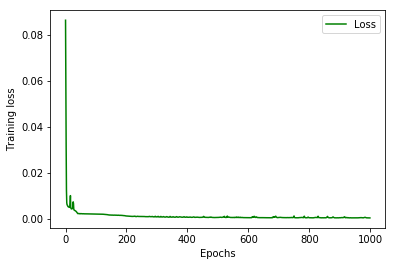

In [11]:
# Training Autoencoder:
iterations = 1000 #500
BatchSize = 1000
trainLoss = []
for epoch in range(iterations):
    runningLoss = 0
    for i in range(TrainImages.size()[0]//BatchSize):
        inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        if use_gpu:
            inputs = Variable(inputs).cuda()
        else:
            inputs = Variable(inputs)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        runningLoss += loss.data[0]
    trainLoss.append(runningLoss/(TrainImages.size()[0]/BatchSize))
    if epoch%100 == 0:
        print('At Iteration : %d / %d  ;  Mean-Squared Error : %f'%(epoch + 1,iterations,runningLoss/
                                                                (TrainImages.size()[0]/BatchSize)))
print('Finished Training')


fig = plt.figure()        
plt.plot(range(epoch+1),trainLoss,'g-',label='Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Training loss')

**I had initially copied all of these weights and kept it aside. Now, here is a small function in order to display plot out these matrices in terms of an image and to display these ones.**

In [12]:
# Encoder Weights Visualization:
# functions to show an image

def imshow(img, strlabel):
    npimg = img.numpy()
    npimg = np.abs(npimg)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size
    plt.figure()
    plt.title(strlabel)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

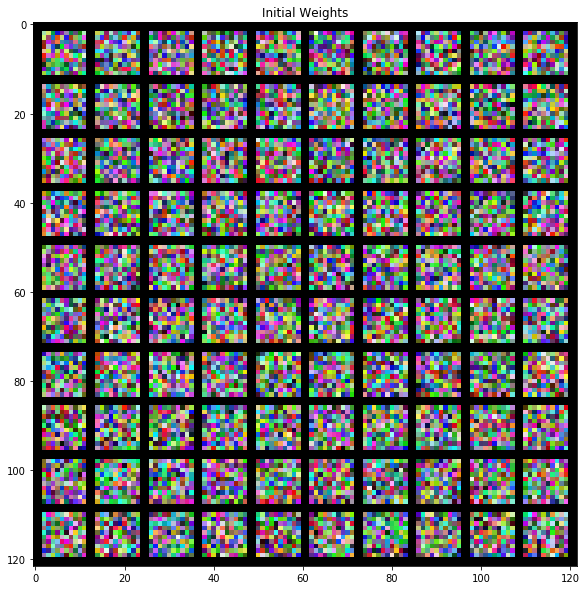

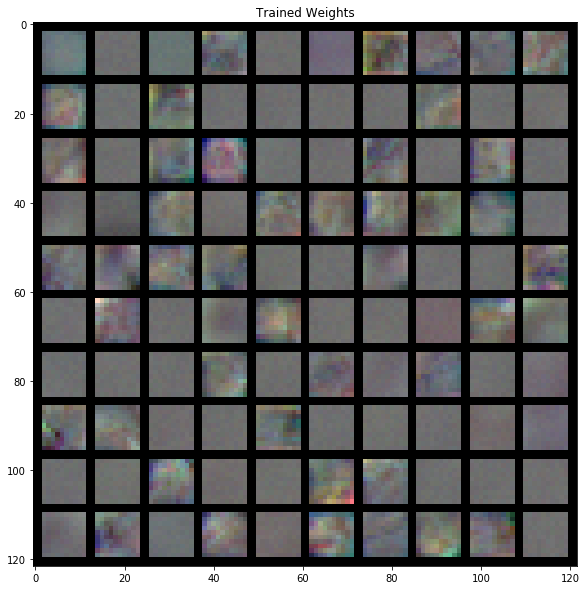

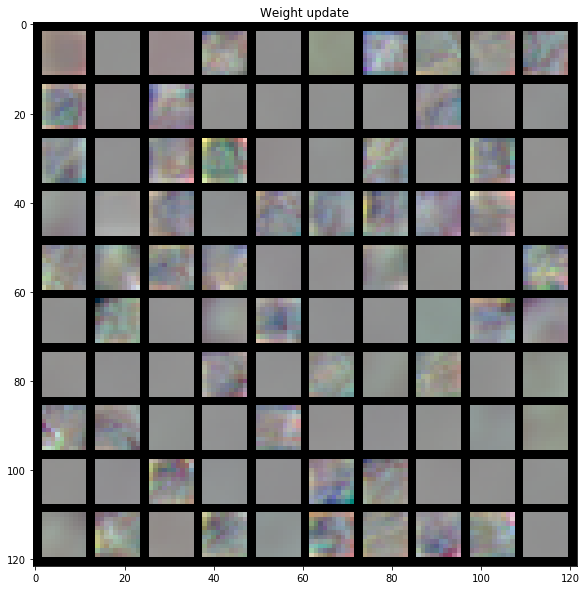

In [13]:
trained_weights = copy.deepcopy(net.encoder[0].weight.data)
d_weights = init_weights - trained_weights 

if use_gpu:
    init_weights = init_weights.view(100,3,10,10).cpu()
    trained_weights = trained_weights.view(100,3,10,10).cpu()
    d_weights = d_weights.view(100,3,10,10).cpu()
else:
    init_weights = init_weights.view(100,3,10,10)
    trained_weights = trained_weights.view(100,3,10,10)
    d_weights = d_weights.view(100,3,10,10)

imshow(torchvision.utils.make_grid(init_weights,nrow=10,normalize=True),'Initial Weights')
imshow(torchvision.utils.make_grid(trained_weights,nrow=10,normalize=True),'Trained Weights')
imshow(torchvision.utils.make_grid(d_weights,nrow=10,normalize=True), 'Weight update')

**I have trained the auto encoder. So, representation learning is done. Now, I would need to actually do a classification. So, I will have to modify the network, I have to throw down everything on my decoder and replace that with just a sequential connection. So, I have my second hidden layers output which is just 100 neurons, those have to be connected down to 100 such features because on my output side, I have 10 X 10 map of all the pixels.**

In [14]:
# Modifying the autoencoder for classification:
new_classifier = nn.Sequential(*list(net.children())[:-1])
net = new_classifier
net.add_module('classifier', nn.Sequential(nn.Linear(patchH*patchW, patchH*patchW),nn.Sigmoid()))
print(net)
if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()

Sequential(
  (0): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Sigmoid()
  )
)


**Now, my next point is actually to train it out as a classifier. So, here I had changed out my criterion function or loss function to a BCELoss as with any kind of a classifier and I still go on to use Adam optimizer itself.**

In [15]:
# Training Classifier:
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


At Iteration: 1 / 1000  ;  Training Loss: 0.536363 
At Iteration: 101 / 1000  ;  Training Loss: 0.244587 
At Iteration: 201 / 1000  ;  Training Loss: 0.199314 
At Iteration: 301 / 1000  ;  Training Loss: 0.178213 
At Iteration: 401 / 1000  ;  Training Loss: 0.169834 
At Iteration: 501 / 1000  ;  Training Loss: 0.163858 
At Iteration: 601 / 1000  ;  Training Loss: 0.159562 
At Iteration: 701 / 1000  ;  Training Loss: 0.152836 
At Iteration: 801 / 1000  ;  Training Loss: 0.149130 
At Iteration: 901 / 1000  ;  Training Loss: 0.148650 
Finished Training


Text(0,0.5,'Training loss')

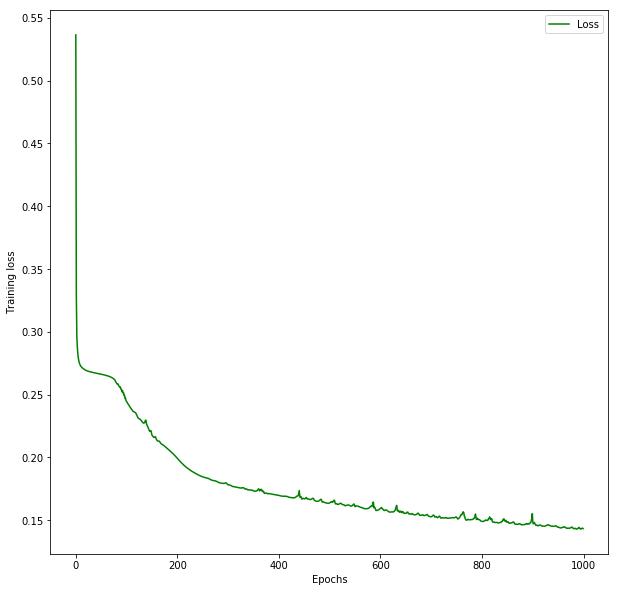

In [16]:
iterations = 1000 #500
BatchSize = 1000
trainLoss = []
for epoch in range(iterations): # loop over the dataset multiple times
    runningLoss = 0
    for i in range(TrainImages.size()[0]//BatchSize):
        inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        labels = torch.index_select(TrainLabels,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad() # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, labels) # calculate loss
        loss.backward() #  backpropagate the loss
        optimizer.step()
        runningLoss += loss.data[0]
    trainLoss.append(runningLoss/(TrainImages.size()[0]/BatchSize))
    if epoch%100 == 0:
        print('At Iteration: %d / %d  ;  Training Loss: %f '%(epoch + 1,iterations,runningLoss/(TrainImages.size()[0]/BatchSize)))
print('Finished Training')

fig = plt.figure()        
plt.plot(range(epoch+1),trainLoss,'g-',label='Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Training loss')

Testing Performance:

In [17]:
TestDatapath = 'DRIVE/test/images/'  # Test Image Data Path
TestLabelpath = 'DRIVE/test/1st_manual/'  # Test Image Manual Label

In [18]:

# Load Images and Convert Images into numpy array

imD = Image.open(TestDatapath + '01_test.tif')
imD = np.array(imD) 
imD = imD/255.0
    
imL = Image.open(TestLabelpath + '01_manual1.gif')
imL = np.array(imL)
imL = imL/255.0

In [19]:
# Break the image into 10 x 10 patches and push the patches into the network for vessel detection

TestArr = np.zeros(patchH*patchW*3)
imout = np.zeros((imD.shape[0],imD.shape[1]))

for i in range(imD.shape[0]//patchH):
    for j in range(imD.shape[1]//patchW):
        for l1 in range(3):
            for l2 in range(patchH):
                for l3 in range(patchW):
                    TestArr[l1*patchH*patchW + l2*patchW + l3] = imD[i*patchH +l2][j*patchW+l3][l1]
        TestTensor = torch.from_numpy(TestArr)
        out = net(Variable(TestTensor.double().cuda()))
        outArr = out.data.cpu().numpy()
        for l2 in range(patchH):
            for l3 in range(patchW):
                imout[i*patchH +l2][j*patchW+l3] = outArr[l2*patchW + l3]

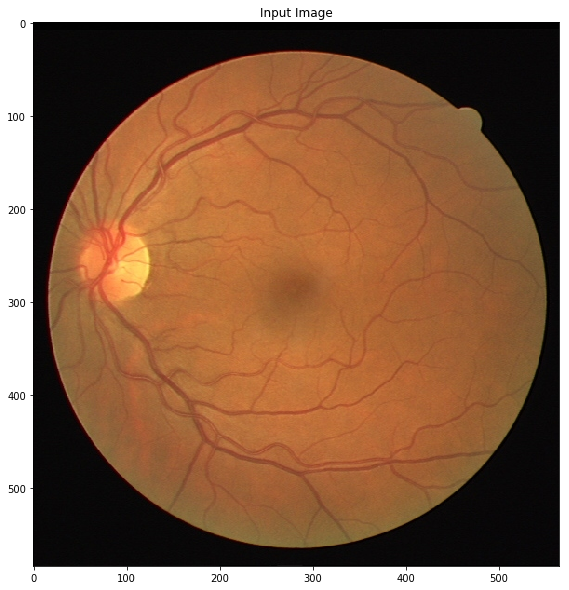

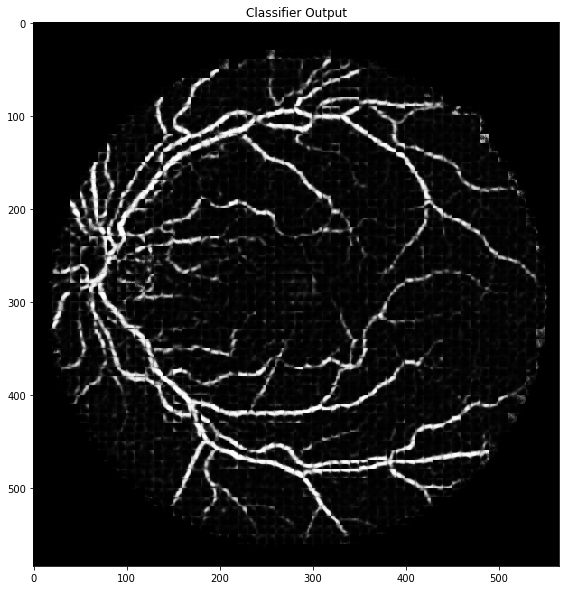

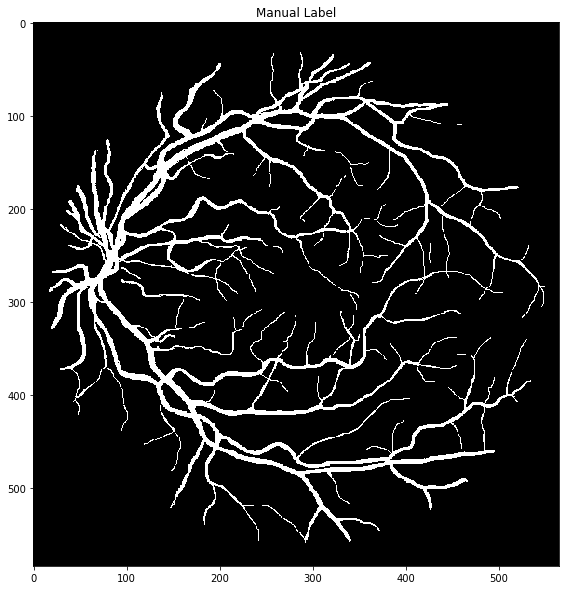

In [20]:
# Display results

plt.figure()
plt.title('Input Image')
plt.imshow(imD)

plt.figure()
plt.title('Classifier Output')
plt.imshow(imout, 'gray')

plt.figure()
plt.title('Manual Label')
plt.imshow(imL, 'gray')